# Benchmark Notebook
This notebook shows a quick python interface usage of the package `sr-metric`.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tifffile
import mrcfile
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import pandas as pd
from scipy.fftpack import fft2, fftshift

# Add the relative path to ../SRmetric
sys.path.append(os.path.abspath(os.path.join('..')))

from SRmetric.metric import *

## Load Image

In [2]:
# WF_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3_20241031_130414_WF.tif"
# SR_PATH = "../data/tirf-sim/HighNA/RBLCell6_pc50pw50_NA160_cyc3.mrc"

WF_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3_20241031_145214_WF.tif"
SR_PATH = "../data/tirf-sim/HighNA/RBLCell12_pc50pw50_768NA160_cyc3.mrc"

In [3]:
def im_read(path):
    file_name, file_extension = os.path.splitext(path)

    if file_extension in [".tif",".tiff"]:
        return tifffile.imread(path)
    elif file_extension == ".mrc":
        with mrcfile.open(path, permissive=True) as mrc:
            # Access the data
            mrc_data = mrc.data
            print("voxel size:",mrc.voxel_size)
        return np.transpose(mrc_data,axes=(0,2,1))
    else:
        raise NotImplementedError("File type {} not supported".format(file_extension))

In [4]:
wf_img = im_read(WF_PATH)
sr_img = im_read(SR_PATH)

print(wf_img.shape)
print(sr_img.shape)

voxel size: (0.03065, 0.03065, 0.05)
(1536, 1536)
(3, 1536, 1536)


/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:206: RuntimeWarning: Map ID string not found - not an MRC file, or file is corrupt
  warnings.warn(msg, RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
/home/jackyko/mambaforge/envs/sr-metric/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:238: RuntimeWarning: Machine stamp '0x00 0x00 0x00 0x00' does not match the apparent byte order '>'
  warnings.warn(msg.format(pretty_machst, header.mode.dtype.byteorder),


In [5]:
# Define a custom colormap: cyan to white to hot
colors_cyan = [
    (0.0, "black"),   # Start with cyan
    (0.7, "cyan"),   # Start with cyan
    (1.0, "white")     # End with hot (red at high values)
]
cyan_hot_cmap = LinearSegmentedColormap.from_list("cyan_hot", colors_cyan)

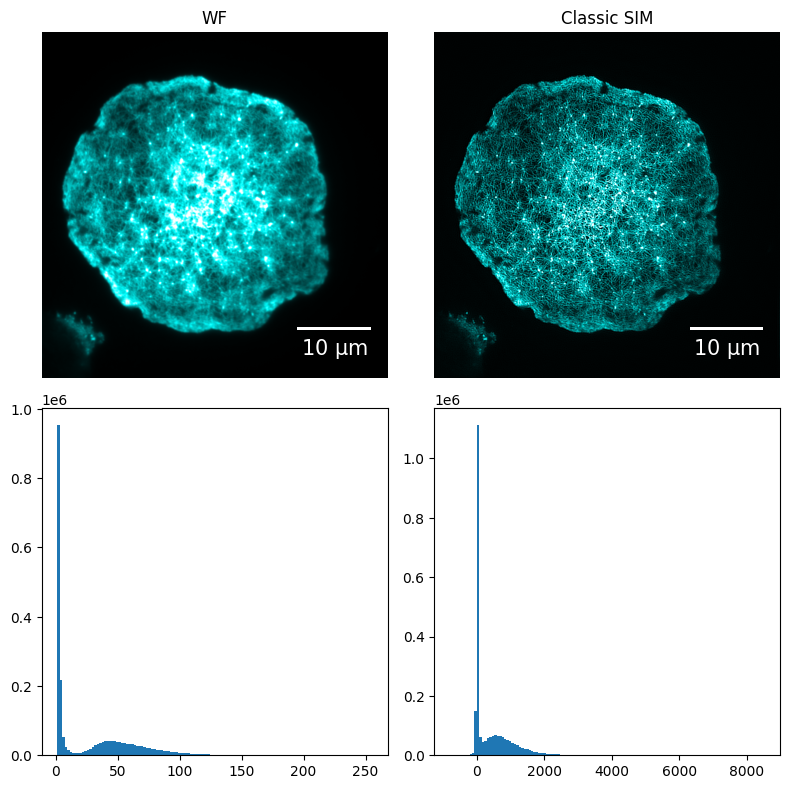

In [6]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs[0,0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0,0].set_axis_off()
axs[0,0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,0].add_artist(scalebar)
axs[1,0].hist(wf_img.ravel(),bins=128)

axs[0,1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[0,1].set_axis_off()
axs[0,1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(0.03065, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,1].add_artist(scalebar)
axs[1,1].hist(sr_img[0].ravel(),bins=128)

fig.tight_layout()

## Performance Benchmark

Image Relative Metric:
nMSE     7.463718
PSNR    19.169237
SSIM     0.291221
PCC      0.885386
MI       0.934972
dtype: float64
1/7 Frequency Value (Normalized): 0.3700
Real Resolution: 0.17 um
1/7 Frequency Value (Normalized) [img1]: 0.9400
Real Resolution [img1]: 0.13 um
1/7 Frequency Value (Normalized) [img2]: 0.9300
Real Resolution [img2]: 0.07 um


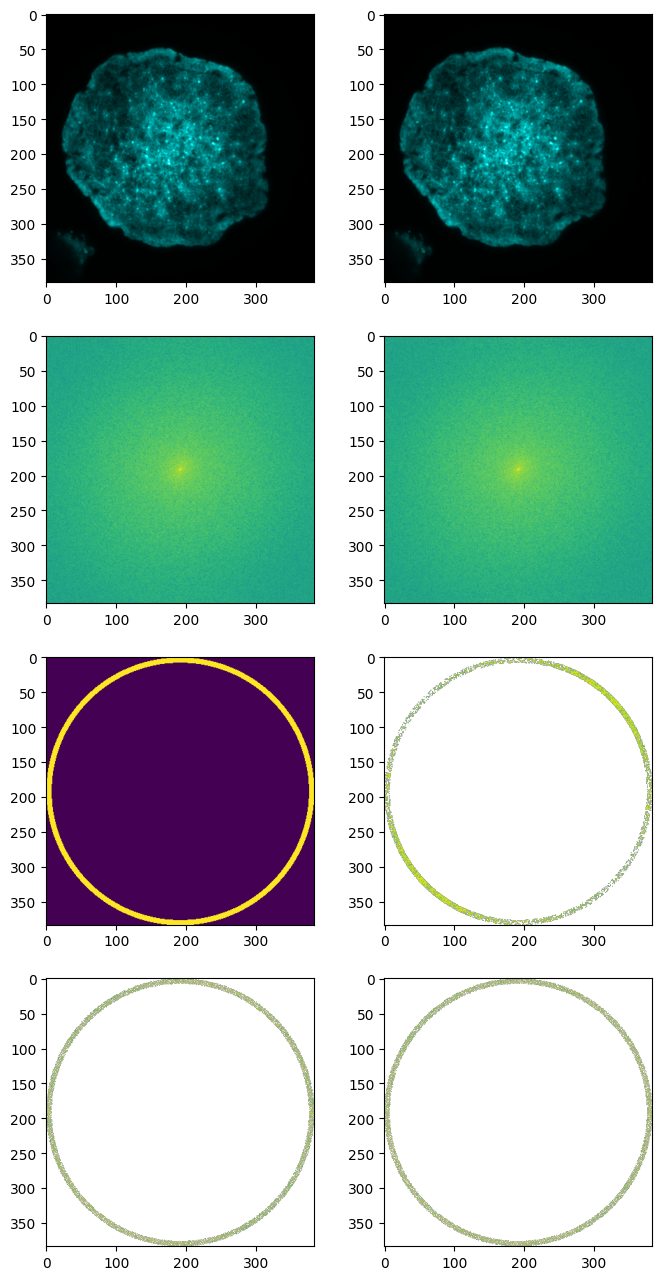

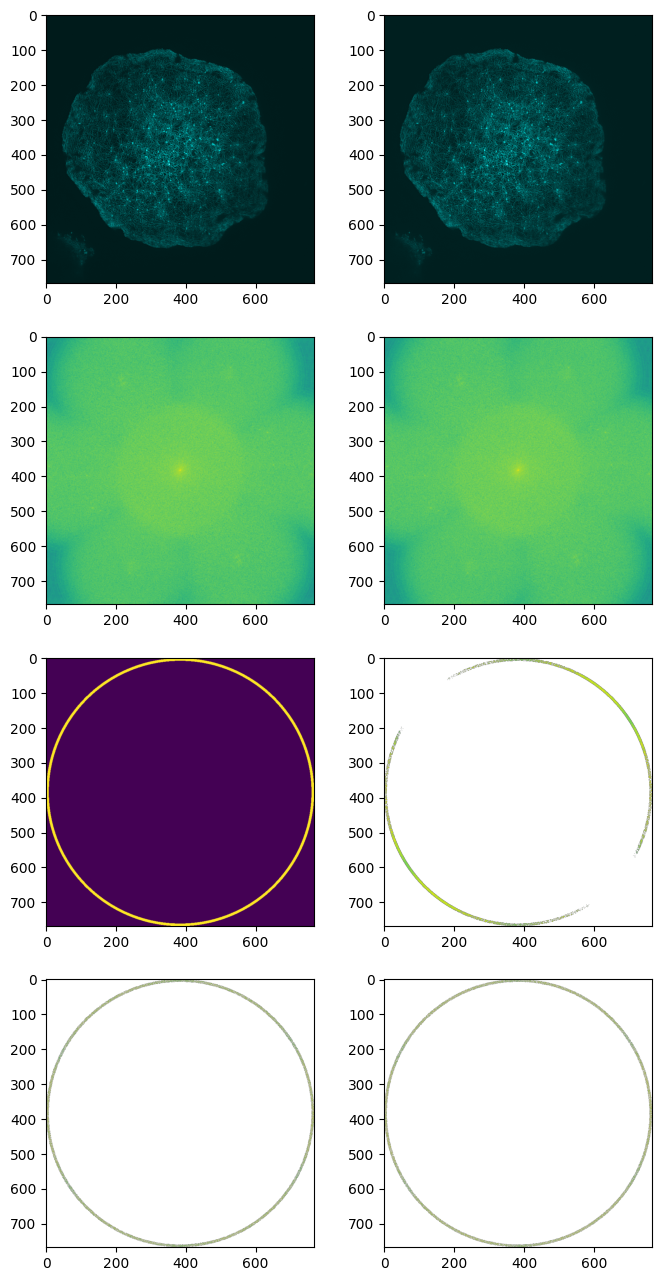

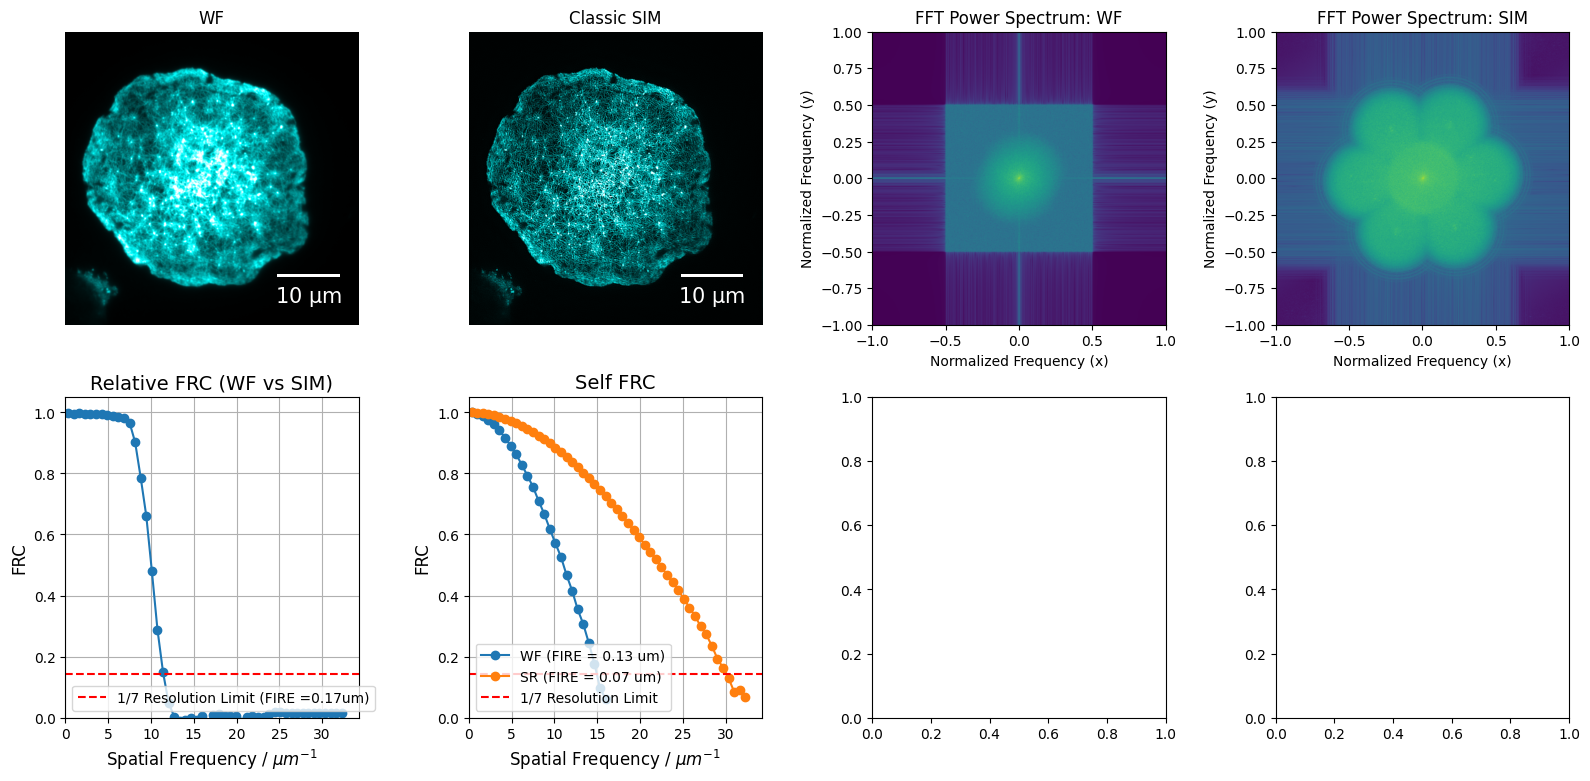

In [7]:
class SRMetric:
    """
    A Python class object to compute 

    Attributes:
    -----------
    img1: numpy.ndarray
        2D numpy array of pre-processed image
    img2: numpy.ndarray
        2D numpy array of processed image
    pixel_size: float
        Physical pixel size of the image, in um
    """
    def __init__(self, 
                 img1,
                 img2,
                 pixel_size=1,
                 verbose = True,
                 ):
        assert len(img1.shape) == 2, "img1 must be a 2D numpy array"
        self.img1 = img1
        assert len(img2.shape) == 2, "img2 must be a 2D numpy array"
        self.img2 = img2

        assert img1.shape == img2.shape, "Both images must have the same shape."

        self.pixel_size=pixel_size

        self.verbose = verbose

    def compute_nMSE(self):
        img1_norm = (self.img1 - np.min(self.img1))/(np.max(self.img1)-np.min(self.img2))
        img2_norm = (self.img2 - np.min(self.img2))/(np.max(self.img2)-np.min(self.img2))

        # Compute the squared norm of the difference
        diff_squared = np.sum((img1_norm - img2_norm) ** 2)
        
        # Compute the squared norm of the reference image
        norm_squared = np.sum(img1_norm ** 2)
        
        # Compute NMSE
        nMSE = diff_squared / norm_squared
        return nMSE

    def compute_PSNR(self):
        """
        Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.
                
        Returns:
            float: The PSNR value in decibels (dB).
        """

        img1_norm = (self.img1 - np.min(self.img1))/(np.max(self.img1)-np.min(self.img2))
        img2_norm = (self.img2 - np.min(self.img2))/(np.max(self.img2)-np.min(self.img2))
        mse = np.mean((img1_norm - img2_norm) ** 2)
        if mse == 0:
            return float('inf')  # Infinite PSNR if images are identical
        
        max_value = 1 # max value of the image input
        psnr = 10 * np.log10((max_value ** 2) / mse)
        return psnr
    
    def compute_SSIM(self, c1=1e-4, c2=9e-4):
        """
        Compute the Structural Similarity Index (SSIM) between two images.
        
        Parameters:
            c1 (float): Small constant to stabilize the division (default: 1e-4).
            c2 (float): Small constant to stabilize the division (default: 9e-4).
        
        Returns:
            float: The SSIM value.
        """
        img1_norm = (self.img1 - np.min(self.img1))/(np.max(self.img1)-np.min(self.img2))
        img2_norm = (self.img2 - np.min(self.img2))/(np.max(self.img2)-np.min(self.img2))

        # Means
        mu1 = np.mean(img1_norm)
        mu2 = np.mean(img2_norm)
        
        # Variances and Covariance
        sigma1_sq = np.mean((img1_norm - mu1) ** 2)
        sigma2_sq = np.mean((img2_norm - mu2) ** 2)
        sigma12 = np.mean((img1_norm - mu1) * (img2_norm - mu2))
        
        # SSIM formula
        ssim = ((2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)) / ((mu1 ** 2 + mu2 ** 2 + c1) * (sigma1_sq + sigma2_sq + c2))
        return ssim

    def compute_PCC(self):
        """
        Compute the Pearson Correlation Coefficient (PCC) between two images.
        
        Returns:
            float: The PCC value.
        """
        img1_norm = (self.img1 - np.min(self.img1))/(np.max(self.img1)-np.min(self.img2))
        img2_norm = (self.img2 - np.min(self.img2))/(np.max(self.img2)-np.min(self.img2))

        # Flatten the images to compute covariance and variance
        image1_flat = img1_norm.flatten()
        image2_flat = img2_norm.flatten()
        
        # Means
        mean1 = np.mean(image1_flat)
        mean2 = np.mean(image2_flat)
        
        # Covariance and standard deviations
        covariance = np.mean((image1_flat - mean1) * (image2_flat - mean2))
        std1 = np.std(image1_flat)
        std2 = np.std(image2_flat)
        
        pcc = covariance / (std1 * std2)
        return pcc
    
    def compute_mutual_info(self, bins=256):
        """
        Compute the Mutual Information (MI) between two images.
        
        Parameters:
            bins (int): The number of bins to use for the histogram (default: 256).
        
        Returns:
            float: The MI value.
        """
        img1_norm = (self.img1 - np.min(self.img1))/(np.max(self.img1)-np.min(self.img2))
        img2_norm = (self.img2 - np.min(self.img2))/(np.max(self.img2)-np.min(self.img2))

        # Compute the joint histogram
        joint_hist, _, _ = np.histogram2d(img1_norm.ravel(), img2_norm.ravel(), bins=bins)
        
        # Normalize the histogram to get the joint probability distribution
        joint_prob = joint_hist / np.sum(joint_hist)
        
        # Compute the marginal probabilities
        prob1 = np.sum(joint_prob, axis=1)
        prob2 = np.sum(joint_prob, axis=0)
        
        # Compute mutual information
        mi = 0.0
        for i in range(joint_prob.shape[0]):
            for j in range(joint_prob.shape[1]):
                if joint_prob[i, j] > 0:
                    mi += joint_prob[i, j] * np.log(joint_prob[i, j] / (prob1[i] * prob2[j]))

        return mi

    def compute_frc(self, num_bins=50, resolution_limit=1/7):
        """
        Computes the Fourier Ring Correlation (FRC) between two images.

        Parameters:
            num_bins: Number of frequency bins for the correlation.
            resolution_limit: Resolution threshold limit
        
        Returns:
            frequencies: Array of spatial frequencies.
            frc_values: Array of FRC values.
        """
        # Compute Fourier transforms and magnitudes
        fft_1 = fftshift(fft2(self.img1))
        fft_2 = fftshift(fft2(self.img2))
        mag1 = np.abs(fft_1)
        mag2 = np.abs(fft_2)
        
        # Create coordinate grid
        ny, nx = self.img1.shape
        y, x = np.indices((ny, nx)) - np.array([ny // 2, nx // 2])[:, None, None]
        radius = np.sqrt(x**2 + y**2)
        max_radius = np.min([ny, nx]) // 2  # Nyquist limit

        # Bin frequencies into rings
        bins = np.linspace(0, max_radius, num_bins + 1)
        frc_values = []
        for i in range(len(bins) - 1):
            # Mask for the current ring
            mask = (radius >= bins[i]) & (radius < bins[i+1])
            num_points = np.sum(mask)
            if num_points > 0:
                # Compute FRC for the ring
                numerator = np.sum((fft_1[mask] * np.conj(fft_2[mask])).real)
                denominator = np.sqrt(np.sum(mag1[mask]**2) * np.sum(mag2[mask]**2))
                frc_values.append(numerator / denominator)
            else:
                frc_values.append(0)

        # Calculate frequencies as the midpoints of bins
        frequencies = (bins[:-1] + bins[1:]) / 2 / max_radius  # Normalized frequency

        # Find the first frequency where FRC drops below 1/7
        crossing_index = np.where(np.array(frc_values) < resolution_limit)[0]
        if len(crossing_index) == 0:
            raise ValueError("FRC does not drop below 1/7; resolution cannot be determined.")

        frc_cross_frequency = frequencies[crossing_index[0]]

        # Convert normalized frequency to spatial frequency
        spatial_frequency = frc_cross_frequency * (1 / (2 * self.pixel_size))

        # Convert spatial frequency to resolution
        resolution = 1 / spatial_frequency
        return frequencies, np.array(frc_values), resolution, frc_cross_frequency
    
    def compute_self_frc(self, num_bins=50, resolution_limit=1/7, sampling_rate=[1,1], sampling_method="max"):
        frequencies_res = []
        frc_values_res = [] 
        resolution_res = []
        frc_cross_frequency_res = []

        for i, img in enumerate([self.img1,self.img2]):
            fig, axs = plt.subplots(4,2, figsize=(8,16))


            if sampling_method == "max":
                # Ensure the array dimensions are divisible by 2
                assert img.shape[0] % sampling_rate[i] == 0 and img.shape[i] % sampling_rate[i] == 0, "Array dimensions must be divisible by sampling rate {}.".format(sampling_rate[i])

                # Reshape the array then perform max pooling
                reshaped = img.reshape(img.shape[0] // sampling_rate[i], sampling_rate[i], img.shape[1] // sampling_rate[i], sampling_rate[i])
                img = reshaped.max(axis=(1, 3))

            if sampling_method == "max":
                img1 = img[0::2, 0::2]
                img2 = img[1::2, 1::2]
            elif sampling_method == "skipping":
                img1 = img[::int(2*sampling_rate[i]), ::int(2*sampling_rate[i])]
                img2 = img[1*sampling_rate[i]::int(2*sampling_rate[i]), 1*sampling_rate[i]::int(2*sampling_rate[i])]

            # Compute Fourier transforms and magnitudes
            fft_1 = fftshift(fft2(img1))
            fft_2 = fftshift(fft2(img2))
            mag1 = np.abs(fft_1)
            mag2 = np.abs(fft_2)
                       
            # Create coordinate grid
            ny, nx = img1.shape
            y, x = np.indices((ny, nx)) - np.array([ny // 2, nx // 2])[:, None, None]
            radius = np.sqrt(x**2 + y**2)
            max_radius = np.min([ny, nx]) // 2  # Nyquist limit

            # Bin frequencies into rings
            bins = np.linspace(0, max_radius, num_bins//sampling_rate[i] + 1)
            # bins = np.linspace(0, max_radius, num_bins + 1)

            frc_values1 = []
            for j in range(len(bins) - 1):
                # Mask for the current ring
                mask = (radius >= bins[j]) & (radius < bins[j+1])
                num_points = np.sum(mask)
                if num_points > 0:
                    # Compute FRC for the ring
                    numerator = np.sum((fft_1[mask] * np.conj(fft_2[mask])).real)
                    denominator = np.sqrt(np.sum(mag1[mask]**2) * np.sum(mag2[mask]**2))
                    frc_values1.append(numerator / denominator)
                else:
                    frc_values1.append(0)

                if j == (len(bins)-1-1):
                    axs[0,0].imshow(img1,cmap=cyan_hot_cmap)
                    axs[0,1].imshow(img2,cmap=cyan_hot_cmap)
                    axs[1,0].imshow(mag1,norm=colors.LogNorm(vmin=1e-4, vmax=mag1.max()))
                    axs[1,1].imshow(mag2,norm=colors.LogNorm(vmin=1e-4, vmax=mag2.max()))

                    axs[2,0].imshow(mask)
                    num = (fft_1*mask * np.conj(fft_2*mask)).real
                    axs[2,1].imshow(num,norm=colors.LogNorm(vmin=1e-4, vmax=num.max()))
                    axs[3,0].imshow((fft_1*mask).real,norm=colors.LogNorm(vmin=1e-4, vmax=np.max((fft_1*mask).real)))
                    axs[3,1].imshow((fft_2*mask).real,norm=colors.LogNorm(vmin=1e-4, vmax=np.max((fft_2*mask).real)))

            if sampling_method == "max":
                img1 = img[1::2, 0::2]
                img2 = img[0::2, 1::2]
            elif sampling_method == "skipping":
                img1 = img[1*sampling_rate[i]::int(2*sampling_rate[i]), 0::int(2*sampling_rate[i])]
                img2 = img[0::int(2*sampling_rate[i]), 1*sampling_rate[i]::int(2*sampling_rate[i])]

            # Compute Fourier transforms and magnitudes
            fft_1 = fftshift(fft2(img1))
            fft_2 = fftshift(fft2(img2))
            mag1 = np.abs(fft_1)
            mag2 = np.abs(fft_2)

            # Create coordinate grid
            ny, nx = img1.shape
            y, x = np.indices((ny, nx)) - np.array([ny // 2, nx // 2])[:, None, None]
            radius = np.sqrt(x**2 + y**2)
            max_radius = np.min([ny, nx]) // 2  # Nyquist limit

            # Bin frequencies into rings
            bins = np.linspace(0, max_radius, num_bins//sampling_rate[i] + 1)
            # bins = np.linspace(0, max_radius, num_bins + 1)

            frc_values2 = []
            for j in range(len(bins) - 1):
                # Mask for the current ring
                mask = (radius >= bins[j]) & (radius < bins[j+1])
                num_points = np.sum(mask)
                if num_points > 0:
                    # Compute FRC for the ring
                    numerator = np.sum((fft_1[mask] * np.conj(fft_2[mask])).real)
                    denominator = np.sqrt(np.sum(mag1[mask]**2) * np.sum(mag2[mask]**2))
                    frc_values2.append(numerator / denominator)
                else:
                    frc_values2.append(0)

            frc_values = (np.mean([frc_values1,frc_values2],axis=0))
            
            # Calculate frequencies as the midpoints of bins
            frequencies = (bins[:-1] + bins[1:]) / 2 / max_radius  # Normalized frequency

            # Find the first frequency where FRC drops below 1/7
            crossing_index = np.where(frc_values < resolution_limit)[0]
            if len(crossing_index) == 0:
                # raiseValueError("FRC does not drop below 1/7; resolution cannot be determined.")
                frc_cross_frequency, resolution = None, None
            else:
                frc_cross_frequency = frequencies[crossing_index[0]]

                # Convert normalized frequency to spatial frequency
                spatial_frequency = frc_cross_frequency * (1 / (2 * self.pixel_size * sampling_rate[i]))

                # Convert spatial frequency to resolution
                resolution = 1 / spatial_frequency

            frequencies_res.append(frequencies)
            frc_values_res.append(frc_values)
            resolution_res.append(resolution)
            frc_cross_frequency_res.append(frc_cross_frequency)

        return frequencies_res, frc_values_res, resolution_res, frc_cross_frequency_res

    def compute_metric(self):
        res = {
            "nMSE": self.compute_nMSE(),
            "PSNR": self.compute_PSNR(),
            "SSIM": self.compute_SSIM(),
            "PCC": self.compute_PCC(),
            "MI": self.compute_mutual_info(),
            }
        
        res = pd.Series(res)

        if self.verbose:
            print("Image Relative Metric:")
            print(res)

        return res
    
    def compute_resolution_map(self):
        

        return
    

PX_SIZE = 0.03065
SAMPLING_RATE= [2,1]

srmetric = SRMetric(wf_img,sr_img[0],pixel_size=PX_SIZE)
metric = srmetric.compute_metric()

# Compute FRC
freq, frc_val, res, frc_cross_freq = srmetric.compute_frc()
print(f"1/7 Frequency Value (Normalized): {frc_cross_freq:.4f}")
print(f"Real Resolution: {res:.2f} um")

# Compute self FRC
freq_self, frc_val_self, res_self, frc_cross_freq_self = srmetric.compute_self_frc(sampling_rate=SAMPLING_RATE) # the WF image may need to subsample by half
if frc_cross_freq_self[0]:
    print(f"1/7 Frequency Value (Normalized) [img1]: {frc_cross_freq_self[0]:.4f}")
    print(f"Real Resolution [img1]: {res_self[0]:.2f} um")
else:
    print("1/7 Frequency Value (Normalized) [img1]: Undetermined")
    print("Real Resolution [img1]: Undetermined")
if frc_cross_freq_self[1]:
    print(f"1/7 Frequency Value (Normalized) [img2]: {frc_cross_freq_self[1]:.4f}")
    print(f"Real Resolution [img2]: {res_self[1]:.2f} um")
else:
    print("1/7 Frequency Value (Normalized) [img2]: Undetermined")
    print("Real Resolution [img2]: Undetermined")

fig, axs = plt.subplots(2,4,figsize=(16,8))

axs[0,0].imshow(wf_img,vmin=np.percentile(wf_img,1),vmax=np.percentile(wf_img,99.5),cmap=cyan_hot_cmap)
axs[0,0].set_axis_off()
axs[0,0].set_title("WF")
# Add a scale bar
scalebar = ScaleBar(PX_SIZE, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,0].add_artist(scalebar)

axs[0,1].imshow(sr_img[0],vmin=np.percentile(sr_img[0],1),vmax=np.percentile(sr_img[0],99.5),cmap=cyan_hot_cmap)
axs[0,1].set_axis_off()
axs[0,1].set_title("Classic SIM")
# Add a scale bar
scalebar = ScaleBar(PX_SIZE, 
                    units="um",
                    location="lower right",
                    color="white",
                    # length_fraction=0.4,
                    label_loc="top",
                    width_fraction=0.01,
                    fixed_value=10,
                    border_pad=1,
                    # pad=0.2,
                    frameon=False,
                    font_properties={"size":15},
                    ) 
axs[0,1].add_artist(scalebar)

# plot the power spectrum of the input images
fft_1 = fftshift(fft2(wf_img))
# fft_2 = fftshift(fft2(wf_img[1::4,1::4]))

fft_2 = fftshift(fft2(sr_img[0]))
mag1 = np.abs(fft_1)
mag2 = np.abs(fft_2)
power_spectrum1 = np.log(1 + mag1**2)
power_spectrum2 = np.log(1 + mag2**2)    
axs[0,2].imshow(power_spectrum1, cmap='viridis', extent=(-1, 1, -1, 1))
axs[0,2].set_title('FFT Power Spectrum: WF')
axs[0,2].set_xlabel('Normalized Frequency (x)')
axs[0,2].set_ylabel('Normalized Frequency (y)')
axs[0,3].imshow(power_spectrum2, cmap='viridis', extent=(-1, 1, -1, 1))
axs[0,3].set_title('FFT Power Spectrum: SIM')
axs[0,3].set_xlabel('Normalized Frequency (x)')
axs[0,3].set_ylabel('Normalized Frequency (y)')

resolution_limit = 1 / 7  # Resolution Threshold

axs[1,0].plot(freq*(1/PX_SIZE), frc_val, marker='o')
axs[1,0].set_title('Relative FRC (WF vs SIM)' , fontsize=14)
axs[1,0].set_xlabel(r'Spatial Frequency / $\mu m^{-1}$', fontsize=12)
axs[1,0].set_ylabel('FRC', fontsize=12)
axs[1,0].grid(True)
axs[1,0].set_xlim([0, 1.05*(1/PX_SIZE)])
axs[1,0].set_ylim([0, 1.05])
axs[1,0].axhline(y=resolution_limit, color='r', linestyle='--', label=f'1/7 Resolution Limit (FIRE ={res:.2f}um)')
axs[1,0].legend(loc='lower left')  # Include both lines in the legend

labels = ["WF","SR"]
for i, (freq, frc_val, res, frc_cross_freq, label, sampling_rate) in enumerate(zip(freq_self,frc_val_self,res_self,frc_cross_freq_self, labels, SAMPLING_RATE)):
    res = res if res else np.nan
    label = "{} (FIRE = {:.2f} um)".format(label, res)
    axs[1,1].plot(freq*(1/(PX_SIZE*sampling_rate)), frc_val, marker='o',label=label)
axs[1,1].set_title('Self FRC' , fontsize=14)
axs[1,1].set_xlabel(r'Spatial Frequency / $\mu m^{-1}$', fontsize=12)
axs[1,1].set_ylabel('FRC', fontsize=12)
axs[1,1].grid(True)
axs[1,1].set_xlim([0, 1.05*(1/(PX_SIZE*min(SAMPLING_RATE)))])
axs[1,1].set_ylim([0, 1.05])
axs[1,1].axhline(y=resolution_limit, color='r', linestyle='--', label=f'1/7 Resolution Limit')
axs[1,1].legend(loc='lower left')  # Include both lines in the legend

fig.tight_layout()